Подгружаем библиотеки питона

In [ ]:
import numpy as np
import pandas as pd
import scipy

from bs4 import BeautifulSoup
from selenium import webdriver

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import lxml
import csv

import requests

import geopandas as gpd
from shapely.geometry import Point

import time

Мы написали скрипт на <i>Python</i>, который использует библиотеку <i>Selenium</i> для автоматизации веб-браузера. Этот скрипт заходит на сайт RP5, находит таблицу с данными о погоде за сегодня, и сохраняет эти данные в файл формата <b>.csv</b>

In [ ]:
service = Service('C:/chromedriver/chromedriver.exe')
driver = webdriver.Chrome(service=service)

url = "https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B5_(%D0%92%D0%94%D0%9D%D0%A5)"
driver.get(url)

time.sleep(5)

html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

table = soup.find('table', {'id': 'archiveTable'})

data = []

rows = table.find_all('tr')

for row in rows:
    if row.find('td', {'rowspan': True}):
        continue
    row_data = []
    cells = row.find_all(['td', 'th'])[1:]
    for cell in cells:
        row_data.append(cell.get_text(strip=True))
    data.append(row_data)

csv_filename = 'testing.csv'
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(data)

print(f"Данные успешно сохранены в файл {csv_filename}")
driver.quit()


Но однако, мы не совсем мазохисты :), и увидев кнопочку взаимодействия с сайтом <i>"Скачать архив погоды" </i>, ставим максимально доступную дату (с 2005 года по 2024), и записываем в <b>.csv</b> файл

Отчистим наш датасет от ненужных столбцов и пустых строк, выровняем временные интервалы (1,2,4,5 и тд) для часов. Добавим строки для пропущенных часов и заполним их значениями предыдущих строк

Объявим несколько функций: одна из них преобразует значения в колонках, вторая добавляет строки в пропущенные ячейки таблицы. Их всего немного поэтому они не будут нам мешать в предсказании и правильном представлении информации

In [ ]:
def to_numeric_with_exceptions(column):
    try:
        return pd.to_numeric(column)
    except ValueError:
        return column

def add_rows(df):
    new_rows = []
    for name, group in df.groupby(['Year', 'Month', 'Day']):
        if len(group) != 8:
            missing_hours = [hour for hour in range(0, 24, 3) if hour not in group['Hour'].values]

            for hour in missing_hours:
                new_row = {col: np.nan for col in df.columns}
                new_row['Year'] = name[0]
                new_row['Month'] = name[1]
                new_row['Day'] = name[2]
                new_row['Hour'] = hour
                new_rows.append(new_row)

    if new_rows:
        new_rows_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_rows_df], ignore_index=True)
        df.sort_values(by=['Year', 'Month', 'Day', 'Hour'], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return df

Прочитаем нашу базу данных

In [ ]:
df = pd.read_csv('DataBase.csv',
                 delimiter=';',
                 names = ['Year', 'Month', 'Day', 'Hour', #date parameters
                          'Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness', #necessary parameters
                          'Weather', 'LowCl', 'LowPerc', 'Height', 'HighCl1', 'HighCl2', 'Visibility', 'Rainfall'], #unnecessary parameters
                 low_memory=False)

Опишем также представление направления не в вымыщленных единицах а в градусах, где 30 градусов - 1, 45 град - 2 и так далее. Для ячеек с четким направлением на север 1 - возьмем 360 градусов, а где не было ветра, следовательно не имело направления возьмем - 0

<img src="Роза ветров.png" width="500">

In [ ]:
direction_mapping = {
    0: 0,
    1: 90,
    2: 60,
    3: 45,
    4: 30,
    5: 360,
    6: 330,
    7: 315,
    8: 300,
    9: 270,
    10: 240,
    11: 225,
    12: 210,
    13: 180,
    14: 150,
    15: 135,
    16: 120 
}

df['Direction'] = df['Direction'].map(direction_mapping)

Добавим недостающие строки, заполним обязательные для представления поля предыдущими значениями. Уберем первую нулевую строчку и преобразуем все в численный формат

In [19]:
df=add_rows(df)

columns_to_fill = ['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']
df[columns_to_fill] = df[columns_to_fill].ffill()

df = df[1:len(df)]

for col in df.columns:
    df[col] = to_numeric_with_exceptions(df[col])

df.head(8)

,Year,Month,Day,Hour,Temp,Pressure,Humidity,Direction,Power,Cloudiness,Weather,LowCl,LowPerc,Height,HighCl1,HighCl2,Visibility,Rainfall,Wx,Wy
1,2005,2,1,3,-8.6,743.0,89.0,315.0,2.0,100.0,Снег,Слоисто-кучевые,75.0,800.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN,1.414214,-1.414214
2,2005,2,1,6,-8.2,742.8,90.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,2,2.121320,-2.121320
3,2005,2,1,9,-8.6,743.5,89.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,100.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,3,2.121320,-2.121320
4,2005,2,1,12,-7.1,745.0,85.0,315.0,3.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,10,NaN,2.121320,-2.121320
5,2005,2,1,15,-6.6,746.8,83.0,315.0,3.0,100.0,Ливень,Кучевые средние,100.0,450.0,Высококучевые башенкообразные или хлопьевидные.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,NaN,2.121320,-2.121320
6,2005,2,1,18,-7.9,748.7,87.0,330.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,NaN,1.732051,-1.000000
7,2005,2,1,21,-8.9,750.0,83.0,315.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,1,1.414214,-1.414214
8,2005,2,2,0,-9.1,751.0,85.0,315.0,2.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,NaN,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN,1.414214,-1.414214


Выгрузим нашу базу в файл Temp.csv с разделителем ";"

In [ ]:
df.to_csv('Temp.csv', sep=';')

Получим из базы данных значения обязательных параметров за первый месяц 2005 года

In [ ]:
plot_cols = ['Temp', 'Pressure', 'Humidity','Direction', 'Power', 'Cloudiness']

plot_features = df[plot_cols][:1000]
plot_features.index = df.index[:1000]
_ = plot_features.plot(subplots=True)

Выведем статистику по данным за все время: <i>количество строк</i>, <i>среднее значение</i>, <i>ср. кв. отклонение</i>, <i>минимум </i>и <i>максимум</i>

In [ ]:
df.describe().transpose()

Поскольку о данных ветра не совсем удобно судить по такой статистике, то проще представить ее в виде <b>розы ветров</b>. Для этого создадим вектор ветра, но для начала покажем график распределения ненулевых значений ветра

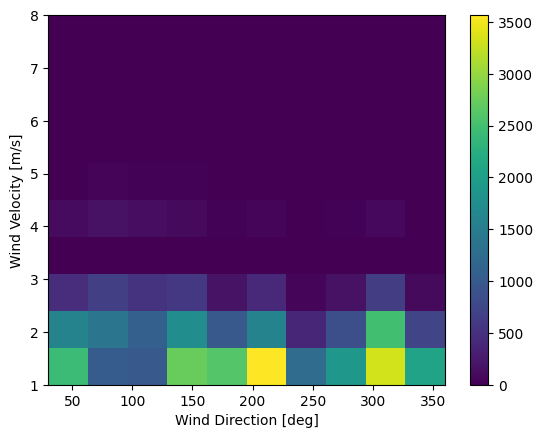

In [20]:
df_filter = df[df['Direction'] != 0.0]

plt.hist2d(df_filter['Direction'], df_filter['Power'])
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

Далее создадим <b>вектор</b> ветра, чтобы проще интерпретировать модель/

In [ ]:
wv = df_filter['Power']
max_wv = df_filter['Power'].max()
wd_rad = df_filter['Direction']*np.pi/180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

А здесь уже представим его на графике,выберем количество точек <i>20x20</i> так как при этом достигается минимальная плотность расставления векторов

(-5.0, 4.330127018922194, -8.0, 7.0)

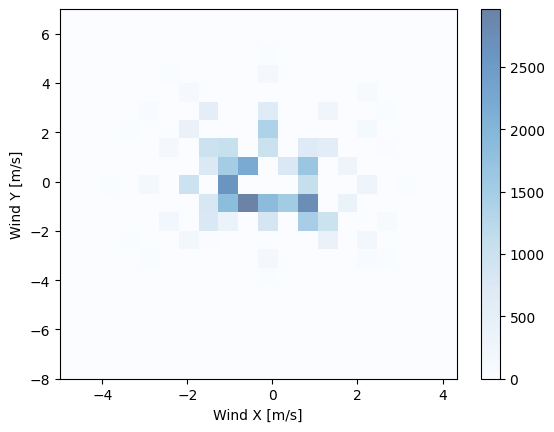

In [21]:
plt.hist2d(df_filter['Wx'], df_filter['Wy'], bins=(20, 20), alpha=0.6, cmap='Blues')
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Давайте наложим эту карту ветров на карту местности, чтобы понять откуда дует :)

Изобразим розу ветров для точки на ВДНХ

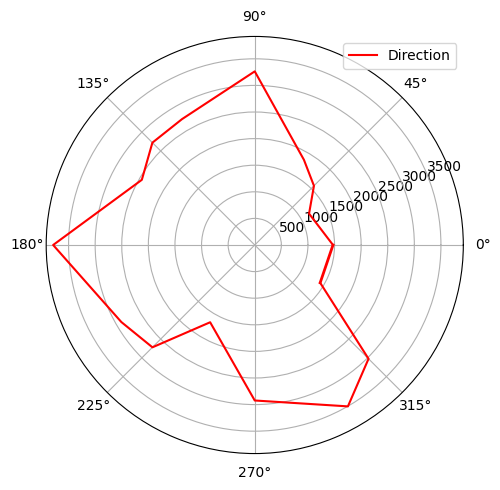

In [73]:
fig = plt.figure(figsize=(10, 5))

total_counts = df_filter['Direction'].value_counts()
angles = df_filter['Direction'].value_counts().index

sort_ang = np.sort(angles)
sorted_counts = total_counts.loc[sort_ang]
sort_ang = total_counts.loc[sort_ang].index * (2*np.pi / 360)

ax = fig.add_subplot(111, projection='polar')
ax.plot(sort_ang, sorted_counts, color='r', label='Direction') 
ax.plot((sort_ang[-1], sort_ang[0]), (sorted_counts.iloc[-1], sorted_counts.iloc[0]), color='r', linewidth=2)

ax.legend()

plt.tight_layout()
plt.show()

Найдем на карте мира Москву, а конкретно ВДНХ. Расположим точку cham_lon и cham_lat на координатах станции, и наложим розу ветров конкретно на точку измерения

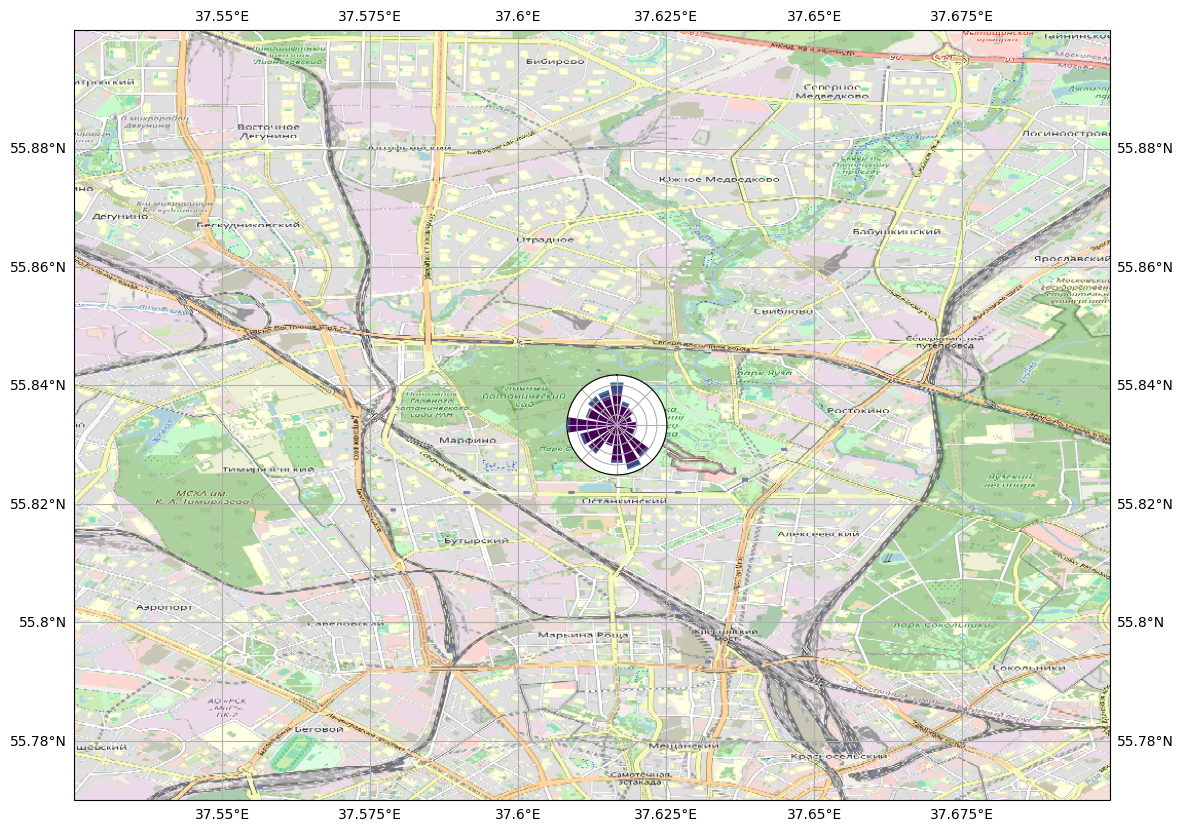

In [89]:
minlon, maxlon, minlat, maxlat = (37.525, 37.7, 55.77, 55.9)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 10))

main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 13)

# Coordinates of the station we were measuring windspeed
cham_lon, cham_lat = (37.616667, 55.833333)

# Inset axe it with a fixed size
wrax_cham = inset_axes(main_ax,
        width=1,                             # size in inches
        height=1,                            # size in inches
        loc='center',                        # center bbox at given position
        bbox_to_anchor=(cham_lon, cham_lat), # position of the axe
        bbox_transform=main_ax.transData,    # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,    # specify the class of the axe
        )

wrax_cham.set_theta_offset( np.pi /2)
wrax_cham.set_theta_direction(-1)

wrax_cham.bar(df_filter['Direction'],df_filter['Power'])


for ax in [wrax_cham]:
  ax.tick_params(labelleft=False, labelbottom=False)